# Keras Callbacks in-build functions

## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import math
import datetime
import pandas as pd

## Examples of Callbacks

### Using Horse/Human datasets

In [4]:
path = "./tensorflow_datasets"
splits, info = tfds.load('horses_or_humans', data_dir=path,
                        as_supervised=True, with_info=True,
                        split=['train[:80%]', 'train[80%:]', 'test'])

In [5]:
(train_examples, valid_examples, test_examples) = splits

In [6]:
info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_dir='./tensorflow_datasets/horses_or_humans/3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

In [9]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [10]:
SIZE = 150
IMAGE_SIZE = (SIZE, SIZE)

In [11]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)/255.0
    return image, label

In [12]:
BATCH_SIZE = 32 

In [14]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = valid_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

In [15]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

2024-04-03 19:15:04.094048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TensorShape([32, 150, 150, 3])

In [16]:
def build_model(dense_units, input_shape=IMAGE_SIZE + (3,)):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(dense_units, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax')
  ])
  return model

## TensorBoard

- Enable visualizations for TensorBoard.

In [17]:
!rm -rf logs

In [18]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

model.fit(train_batches, 
          epochs=10, 
          validation_data=validation_batches, 
          callbacks=[tensorboard_callback])

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5544 - loss: 0.6770 - val_accuracy: 0.5024 - val_loss: 0.6669
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7004 - loss: 0.6109 - val_accuracy: 0.7659 - val_loss: 0.5654
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7551 - loss: 0.5529 - val_accuracy: 0.8244 - val_loss: 0.4963
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7833 - loss: 0.4836 - val_accuracy: 0.8098 - val_loss: 0.4200
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8275 - loss: 0.4171 - val_accuracy: 0.8244 - val_loss: 0.3620
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8275 - loss: 0.3965 - val_accuracy: 0.9073 - val_loss: 0.3106
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8523 - loss: 0.3518 - val_accuracy: 0.9122 - val_loss: 0.2696
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9205 - loss: 0.2617 - val_accuracy: 0.9220 - val_loss: 0.

In [19]:
%tensorboard --logdir logs #run in Colab only

UsageError: Line magic function `%tensorboard` not found.


## [Model Checkpoint](https://keras.io/api/callbacks/model_checkpoint/)

Callback to save the Keras model or model weights at some frequency.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5', verbose=1),
          ])

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=1, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('saved_model', verbose=1)
          ])

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=2, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('model.h5', verbose=1)
          ])

## [Early stopping](https://keras.io/api/callbacks/early_stopping/)

Stop training when a monitored metric has stopped improving.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=50, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[EarlyStopping(
              patience=3,
              min_delta=0.05,
              baseline=0.8,
              mode='min',
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1)
          ])

## [CSV Logger](https://keras.io/api/callbacks/csv_logger/)

Callback that streams epoch results to a CSV file.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
csv_file = 'training.csv'

model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          callbacks=[CSVLogger(csv_file)
          ])

In [ ]:
pd.read_csv(csv_file).head()

## [Learning Rate Scheduler](https://keras.io/api/callbacks/learning_rate_scheduler/)

Updates the learning rate during training.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
def step_decay(epoch):
	initial_lr = 0.01
	drop = 0.5
	epochs_drop = 1
	lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lr

model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          callbacks=[LearningRateScheduler(step_decay, verbose=1),
                    TensorBoard(log_dir='./log_dir')])

In [ ]:
%tensorboard --logdir log_dir

## [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/)

Reduce learning rate when a metric has stopped improving.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=50, 
          validation_data=validation_batches, 
          callbacks=[ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.2, verbose=1,
                                       patience=1, min_lr=0.001),
                     TensorBoard(log_dir='./log_dir')])

In [ ]:
%tensorboard --logdir log_dir

# Custom Callbacks

## Define a callback class

In [26]:
# Define the Keras model to add callbacks to
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1, activation = 'linear', input_dim = 784))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1), loss='mean_squared_error', metrics=['mae'])
    return model

Then, load the MNIST data for training and testing from Keras datasets API:

In [21]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

Now, define a simple custom callback to track the start and end of every batch of data. During those calls, it prints the index of the current batch.

In [22]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_train_batch_begin(self, batch, logs=None):
        print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

In [27]:
model = get_model()
_ = model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          steps_per_epoch=5,
          verbose=0,
          callbacks=[MyCustomCallback()])

Training: batch 0 begins at 19:40:53.937911
Training: batch 0 ends at 19:40:54.066913
Training: batch 1 begins at 19:40:54.066941
Training: batch 1 ends at 19:40:54.067478
Training: batch 2 begins at 19:40:54.067489
Training: batch 2 ends at 19:40:54.067859
Training: batch 3 begins at 19:40:54.067884
Training: batch 3 ends at 19:40:54.068354
Training: batch 4 begins at 19:40:54.068370
Training: batch 4 ends at 19:40:54.068790


## An overview of callback methods


### Common methods for training/testing/predicting
For training, testing, and predicting, following methods are provided to be overridden.
#### `on_(train|test|predict)_begin(self, logs=None)`
Called at the beginning of `fit`/`evaluate`/`predict`.
#### `on_(train|test|predict)_end(self, logs=None)`
Called at the end of `fit`/`evaluate`/`predict`.
#### `on_(train|test|predict)_batch_begin(self, batch, logs=None)`
Called right before processing a batch during training/testing/predicting. Within this method, `logs` is a dict with `batch` and `size` available keys, representing the current batch number and the size of the batch.
#### `on_(train|test|predict)_batch_end(self, batch, logs=None)`
Called at the end of training/testing/predicting a batch. Within this method, `logs` is a dict containing the stateful metrics result.

### Training specific methods
In addition, for training, following are provided.
#### `on_epoch_begin(self, epoch, logs=None)`
Called at the beginning of an epoch during training.
#### `on_epoch_end(self, epoch, logs=None)`
Called at the end of an epoch during training.


### Usage of `logs` dict
The `logs` dict contains the loss value, and all the metrics at the end of a batch or epoch. Example includes the loss and mean absolute error.

In [28]:
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch,logs: 
    print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))
)

model = get_model()
_ = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=64,
          epochs=3,
          verbose=0,
          callbacks=[callback])

Epoch: 0, Val/Train loss ratio: 1.16
Epoch: 1, Val/Train loss ratio: 0.77
Epoch: 2, Val/Train loss ratio: 1.48


In [29]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.7):
        super(DetectOverfittingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        ratio = logs["val_loss"] / logs["loss"]
        print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

        if ratio > self.threshold:
            print("Stopping training...")
            self.model.stop_training = True

model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[DetectOverfittingCallback()])

Epoch: 0, Val/Train loss ratio: 0.66
Epoch: 1, Val/Train loss ratio: 0.16
Epoch: 2, Val/Train loss ratio: 0.55


Similarly, one can provide callbacks in `evaluate()` calls.

## Custom callback to Visualize predictions

In [8]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [9]:
# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]: 
            t.set_color('green') 
        else: 
            t.set_color('red')
    plt.grid(None)

In [10]:
GIF_PATH = './animation.gif'

In [11]:
class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        self.inputs = inputs
        self.ground_truth = ground_truth
        self.images = []
        self.display_freq = display_freq
        self.n_samples = n_samples

    def on_epoch_end(self, epoch, logs=None):
        # Randomly sample data
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        predictions = np.argmax(self.model.predict(X_test), axis=1)

        # Plot the digits
        display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

        # Save the figure
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))

        # Display the digits every 'display_freq' number of epochs
        if epoch % self.display_freq == 0:
            plt.show()

    def on_train_end(self, logs=None):
        imageio.mimsave(GIF_PATH, self.images, fps=1)

In [12]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

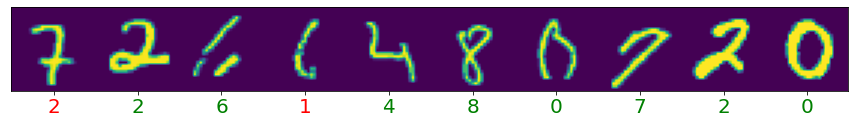

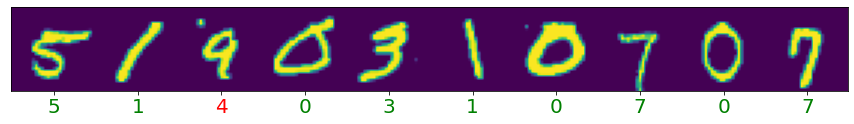

In [ ]:
model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test)])

In [ ]:
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE) 